In [1]:
import os
print(os.getcwd())
os.chdir("..//")
print(os.getcwd())

c:\Users\user\My Drive\PhD\Projects\YONSEI-TAU FL collaboration\EXPFL\XAI
c:\Users\user\My Drive\PhD\Projects\YONSEI-TAU FL collaboration\EXPFL


In [2]:
from models import CNN
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import cv2
from PIL import Image
import utils
import Clients
import os
import sys
import DataManager.datamanager as dm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
from Clients.naive import NaiveClient
from argparse import Namespace
from Clients.base import BaseClient
import torch.nn as nn
from models import VGG
from data_utils import preprocess_img


In [6]:
trainset, testset = dm.ChestXRays()
trainset_subset = torch.utils.data.Subset(trainset, range(0, len(trainset), 200))

trainloader = torch.utils.data.DataLoader(trainset_subset, batch_size=32, shuffle=True, drop_last=False, num_workers=4)
# valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True, drop_last=False, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, drop_last=False, num_workers=4)
class_names = trainset.classes
print("Training size: {} batches; Test size: {} batches.".format(len(trainloader), len(testloader)))

Training size: 1 batches; Test size: 20 batches.


torch.Size([27, 3, 224, 224]) torch.Size([27])
tensor([0, 1])


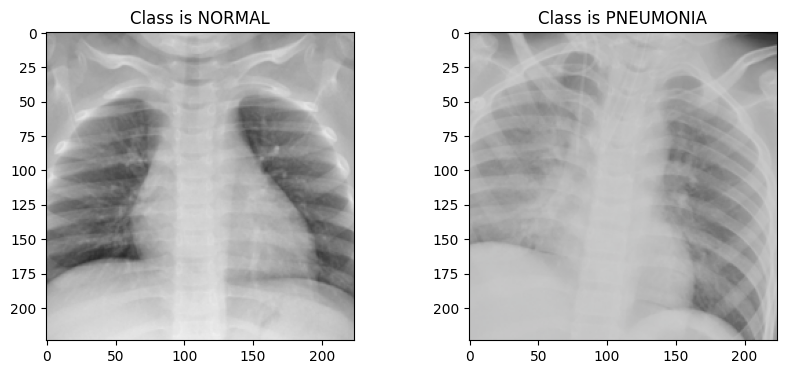

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

inputs, classes = next(iter(trainloader))
print(inputs.shape, classes.shape)
for i in range(len(inputs)):
    if classes[i] != 0:
        continue
    img = inputs[i]
    img = preprocess_img(img)
    axes[0].imshow(img)
    axes[0].set_title("Class is {}".format(class_names[classes[i]]))
    break
inputs, classes = next(iter(trainloader))
print(classes.unique())
for i in range(len(inputs)):
    if classes[i] != 1:
        continue
    img = inputs[i]
    img = preprocess_img(img)
    axes[1].imshow(img)
    axes[1].set_title("Class is {}".format(class_names[classes[i]]))
    break

In [8]:
model = VGG(n_class=2)

In [9]:
args = Namespace(exp_name='EXP', model='VGG', dataset='ChestXRay', optimizer='SGD', lr=1e-3, decay=1e-4, batch_size=64, seed=0)
client = BaseClient(args, 'Naive')
client = NaiveClient(args, 'Naive', dm.ChestXRays)

client.model = utils.build_model(args)
client.model.to(client.device)
client.criterion   = nn.CrossEntropyLoss()
client.optimizer   = torch.optim.Adam(client.model.parameters(), lr=args.lr)

VGG
VGG


In [10]:
num_epochs = 5
for epoch in range(num_epochs):
    print("Epoch: {}/{}".format(epoch + 1, num_epochs))
    client.train()
    client.test()
model = client.model

Epoch: 1/5
Training data instance 0
Training data instance 5
Training data instance 10
Training data instance 15
Training data instance 20
Training data instance 25
Training data instance 30
Training data instance 35
Training data instance 40
Training data instance 45
Training data instance 50
Training data instance 55
Training data instance 60
Training data instance 65
Training data instance 70
Training data instance 75
Training data instance 80
Accuracy: 82.05128205128206%
Epoch: 2/5
Training data instance 0
Training data instance 5
Training data instance 10
Training data instance 15
Training data instance 20
Training data instance 25
Training data instance 30
Training data instance 35
Training data instance 40
Training data instance 45
Training data instance 50
Training data instance 55
Training data instance 60
Training data instance 65
Training data instance 70
Training data instance 75
Training data instance 80
Accuracy: 73.23717948717949%
Epoch: 3/5
Training data instance 0
Trai

In [12]:
# Evaluate on test set
client.test()

Accuracy: 77.72435897435898%


In [21]:
client.save_path = f'../checkpoints/'
client.save_model(tag=1)

In [32]:
print(client.model)
for name, param in client.model.named_parameters():
    print(name, param.size())

VGG(
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=2, bias=True)
  )
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [88]:
# list(client.model.named_parameters()[])
# print(client.model._modules["model"])
# client.model["model.features.7.weight"]
client.model.model.features[12]

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [89]:
input_tensor = None
for idx, (data, target) in enumerate(testloader):
    if idx == 0:
        input_tensor = data
        break

cam = GradCAM(model=client.model.model, target_layers=[client.model.model.features[12]])
grayscale_cams = cam(input_tensor=input_tensor)

In [115]:
int(target[i].numpy())

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


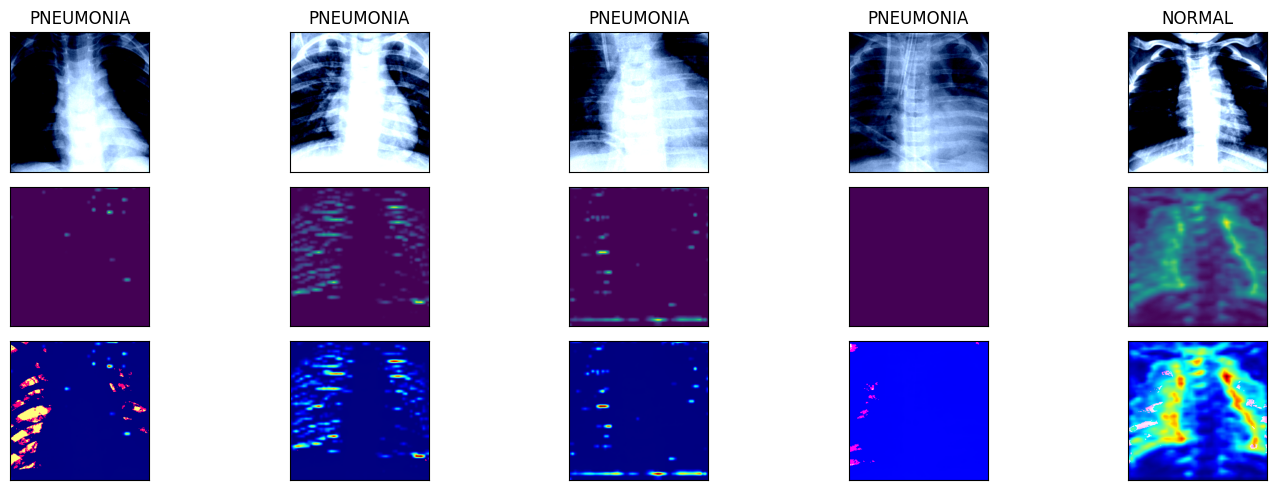

In [132]:
fig, axes = plt.subplots(3, 5, figsize=(15, 5))
for i in range(5):
    
    grayscale_cam = grayscale_cams[i, :]
    rgb_img = np.array(data[i].permute(1, 2, 0)) / 255.0
    target_label = int(target[i].numpy())
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    # Plot figures
    axes[0,i].imshow((rgb_img * 255.0), cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[0,i].set_title(class_names[target_label])
    axes[1,i].imshow(grayscale_cam)
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    axes[2,i].imshow(visualization)
    axes[2,i].set_xticks([])
    axes[2,i].set_yticks([])
plt.tight_layout()
plt.show()